# 🆚 Model Comparison - All 6 Models

Clear comparison of all models across simple questions and images.

**Models tested:**
1. **original** - Base MedGemma (not fine-tuned)
2. **r1_alpha2_epochs1** - LoRA r=1, alpha=2, 1 epoch
3. **r1_alpha4_epochs1** - LoRA r=1, alpha=4, 1 epoch
4. **r1_alpha4_epochs2** - LoRA r=1, alpha=4, 2 epochs
5. **r4_alpha4_epochs2** - LoRA r=4, alpha=4, 2 epochs
6. **r16_alpha16_epochs2** - LoRA r=16, alpha=16, 2 epochs

In [22]:
# Import libraries
import pandas as pd
import glob
from IPython.display import display, HTML, Image, Markdown
import warnings
warnings.filterwarnings('ignore')

# Styling
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

print("✓ Libraries loaded")

✓ Libraries loaded


In [23]:
# Load the most recent results
files = glob.glob('simple_comparison_*.csv')

if files:
    latest = max(files, key=lambda x: x)
    print(f"Loading: {latest}")
    df = pd.read_csv(latest, sep='|')
    print(f"✓ Loaded {len(df)} results")
    print(f"  Models: {df['model'].nunique()}")
    print(f"  Text questions: {len(df[df['type']=='text']) // df['model'].nunique()}")
    print(f"  Image questions: {len(df[df['type']=='image']) // df['model'].nunique()}")
else:
    print("❌ No results found. Run: python simple_test.py")

Loading: simple_comparison_20251014_033331.csv
✓ Loaded 96 results
  Models: 6
  Text questions: 5
  Image questions: 11


## 🧠 Load BraTS Ground Truth Data

Loading the TextBraTS dataset to compare model predictions with ground truth annotations.

In [24]:
# Load TextBraTS dataset for ground truth comparisons
from datasets import load_dataset
import os

print("Loading TextBraTS dataset...")
textbrats = load_dataset("Jupitern52/TextBraTS")
print(f"✓ Loaded {len(textbrats['train'])} samples from TextBraTS")

# Get the first entry (BraTS20_Training_001 - the one used in simple_test.py)
# This corresponds to the brain MRI images we're testing
ground_truth = textbrats['train'][0]

print("\n" + "="*80)
print("GROUND TRUTH for BraTS20_Training_001")
print("="*80)
print(f"\nPatient ID: BraTS20_Training_001")
print(f"Ground Truth Annotation:\n")
print(ground_truth['text'])
print("\n" + "="*80)

# Store for later comparison
gt_text = ground_truth['text']

Loading TextBraTS dataset...
✓ Loaded 369 samples from TextBraTS

GROUND TRUTH for BraTS20_Training_001

Patient ID: BraTS20_Training_001
Ground Truth Annotation:

The lesion area is in the right frontal and parietal lobes with a mixed pattern of high and low signals with speckled high signal regions. Edema is mainly observed in the right parietal lobe, partially extending to the frontal lobe, presenting as high signal, indicating significant tissue swelling around the lesion. Necrosis is within the lesions of the right parietal and frontal lobes, appearing as mixed, with alternating high and low signal regions. Ventricular compression is seen in the lateral ventricles with significant compressive effects on the brain tissue and ventricles.



### Compare Brain MRI Predictions with Ground Truth

In [25]:
# Helper function to compare brain MRI responses with ground truth
def compare_brain_mri_with_ground_truth(category):
    """Compare model responses for brain MRI images with the ground truth."""
    subset = df[(df['type'] == 'image') & (df['category'] == category)]
    
    if len(subset) == 0:
        print(f"No results for: {category}")
        return
    
    row = subset.iloc[0]
    prompt = row['prompt']
    image_path = row['image']
    
    print(f"\n{'='*100}")
    print(f"BRAIN MRI ANALYSIS: {category}")
    print(f"{'='*100}\n")
    
    # Display image
    if image_path:
        display(Image(filename=image_path, width=500))
    
    print(f"\n{'─'*100}")
    print("🎯 GROUND TRUTH (Expert Annotation):")
    print(f"{'─'*100}")
    print(gt_text)
    print(f"\n{'─'*100}")
    print("🤖 MODEL RESPONSES:")
    print(f"{'─'*100}\n")
    
    # Create comparison table with ground truth context
    comparison_data = []
    for _, model_row in subset.iterrows():
        comparison_data.append({
            'Model': model_row['model'],
            'Response': model_row['response'],
            'Length': model_row['length'],
            'Time (s)': model_row['time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    display(comparison_df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'vertical-align': 'top'
    }).hide(axis='index'))
    
    # Quick analysis
    print(f"\n{'─'*100}")
    print("📊 QUICK COMPARISON:")
    print(f"{'─'*100}")
    print(f"Ground truth length: {len(gt_text)} characters")
    print(f"Average model response length: {comparison_df['Length'].mean():.0f} characters")
    print(f"Response length range: {comparison_df['Length'].min()}-{comparison_df['Length'].max()} characters")
    print(f"Average generation time: {comparison_df['Time (s)'].mean():.2f} seconds")
    print(f"{'─'*100}\n")

#### Single Slice Brain MRI vs Ground Truth


BRAIN MRI ANALYSIS: Brain MRI - Single Slice



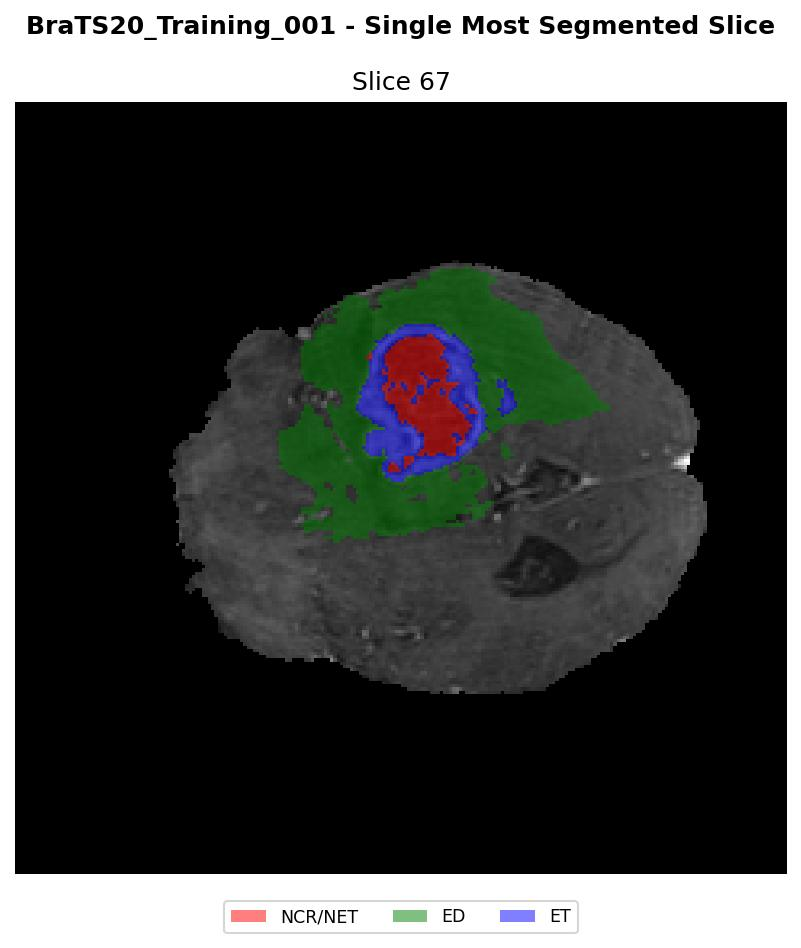


────────────────────────────────────────────────────────────────────────────────────────────────────
🎯 GROUND TRUTH (Expert Annotation):
────────────────────────────────────────────────────────────────────────────────────────────────────
The lesion area is in the right frontal and parietal lobes with a mixed pattern of high and low signals with speckled high signal regions. Edema is mainly observed in the right parietal lobe, partially extending to the frontal lobe, presenting as high signal, indicating significant tissue swelling around the lesion. Necrosis is within the lesions of the right parietal and frontal lobes, appearing as mixed, with alternating high and low signal regions. Ventricular compression is seen in the lateral ventricles with significant compressive effects on the brain tissue and ventricles.

────────────────────────────────────────────────────────────────────────────────────────────────────
🤖 MODEL RESPONSES:
─────────────────────────────────────────────────────

Model,Response,Length,Time (s)
original,"Based on the MRI scan, here are the regions and structures I can identify: * **Gray Matter:** This is the outer layer of the brain and is responsible for higher-level functions like thinking, learning, and memory. The gray matter is depicted in red in the image. * **White Matter:** This is the inner layer of the brain and is composed of nerve fibers that connect different regions of the brain. The white matter is depicted in blue in the image. * **Cerebrospinal Fluid (CSF):** This fluid surrounds the brain and spinal cord and provides cushioning and nutrients. The CSF is depicted in green in the image. * **Nonsynonymous Coding Region (NCNR):** This is a region of the brain that is not involved in any specific function. It is depicted in red in the image. * **Extracellular Space (ED):** This is the space between cells in the brain. It is depicted in",871,11.910000
r1_alpha2_epochs1,"The MRI slice demonstrates: The lesion area is in the right cerebral hemisphere, mainly concentrated in the right frontal and parietal lobes with mixed signals of varying intensities, including areas of high and low signal, with some spotted high signal areas. Edema is observed in the right parietal and frontal lobes, with a relatively large area of edema, suggesting significant tissue swelling. Ventricular compression is observed with the right lateral ventricle being compressed.",485,4.600000
r1_alpha4_epochs1,"The MRI slice demonstrates: The lesion area is in the right frontal and parietal lobes with a mix of high and low signals with speckled high-signal areas, suggesting multiple lesions. Edema is observed in the right frontal and parietal lobes, with a significant degree of swelling, indicating a severe degree of tissue damage. Necrosis is visible in the right frontal and parietal lobes with a mixture of high and low signals, suggesting necrotic tissue. Ventricular compression is not observed, with the ventricles appearing relatively normal.",544,5.530000
r1_alpha4_epochs2,"The MRI slice demonstrates: The lesion area is in the right frontal lobe, right parietal lobe, and right occipital lobe with mixed signals of varying intensity and spotted high-signal areas. Edema is observed with uniform high signals in the right frontal lobe and right parietal lobe, extending to parts of the right occipital lobe. Necrosis is suggested by some low-signal regions, mainly concentrated in the right frontal and right parietal lobes. Ventricular compression is evident with compression of the right ventricle, with deformation of its shape.",557,5.760000
r4_alpha4_epochs2,"The MRI slice demonstrates: The lesion area is in the right parietal lobe with a mixture of heterogeneous high and low signals, accompanied by speckled high signal areas. Edema is observed in the right parietal lobe, with a significant degree of swelling in the surrounding tissues, indicating a severe inflammatory response. Ventricular compression is observed, with the right ventricle showing signs of compression, appearing deformed and narrowed.",450,4.290000
r16_alpha16_epochs2,"Analysis of this brain MRI reveals: The lesion area is in the right cerebral hemisphere, particularly in the frontal and parietal lobes, with a mixture of heterogeneous high and low signals, accompanied by speckled high signal areas. Edema is significant in the right frontal and parietal regions, with considerable swelling of the surrounding tissues, indicating a severe level of tissue damage. Necrosis is suggested by some low signal areas in the right parietal lobe, with mixed signal intensity, suggesting potential necrosis that is relatively dispersed. Ventricular compression is observed with the right lateral ventricle noticeably compressed, while the left lateral ventricle shows slight deformation.",711,6.530000



────────────────────────────────────────────────────────────────────────────────────────────────────
📊 QUICK COMPARISON:
────────────────────────────────────────────────────────────────────────────────────────────────────
Ground truth length: 586 characters
Average model response length: 603 characters
Response length range: 450-871 characters
Average generation time: 6.44 seconds
────────────────────────────────────────────────────────────────────────────────────────────────────



In [26]:
compare_brain_mri_with_ground_truth('Brain MRI - Single Slice')

#### Three Slices Brain MRI vs Ground Truth


BRAIN MRI ANALYSIS: Brain MRI - Three Slices



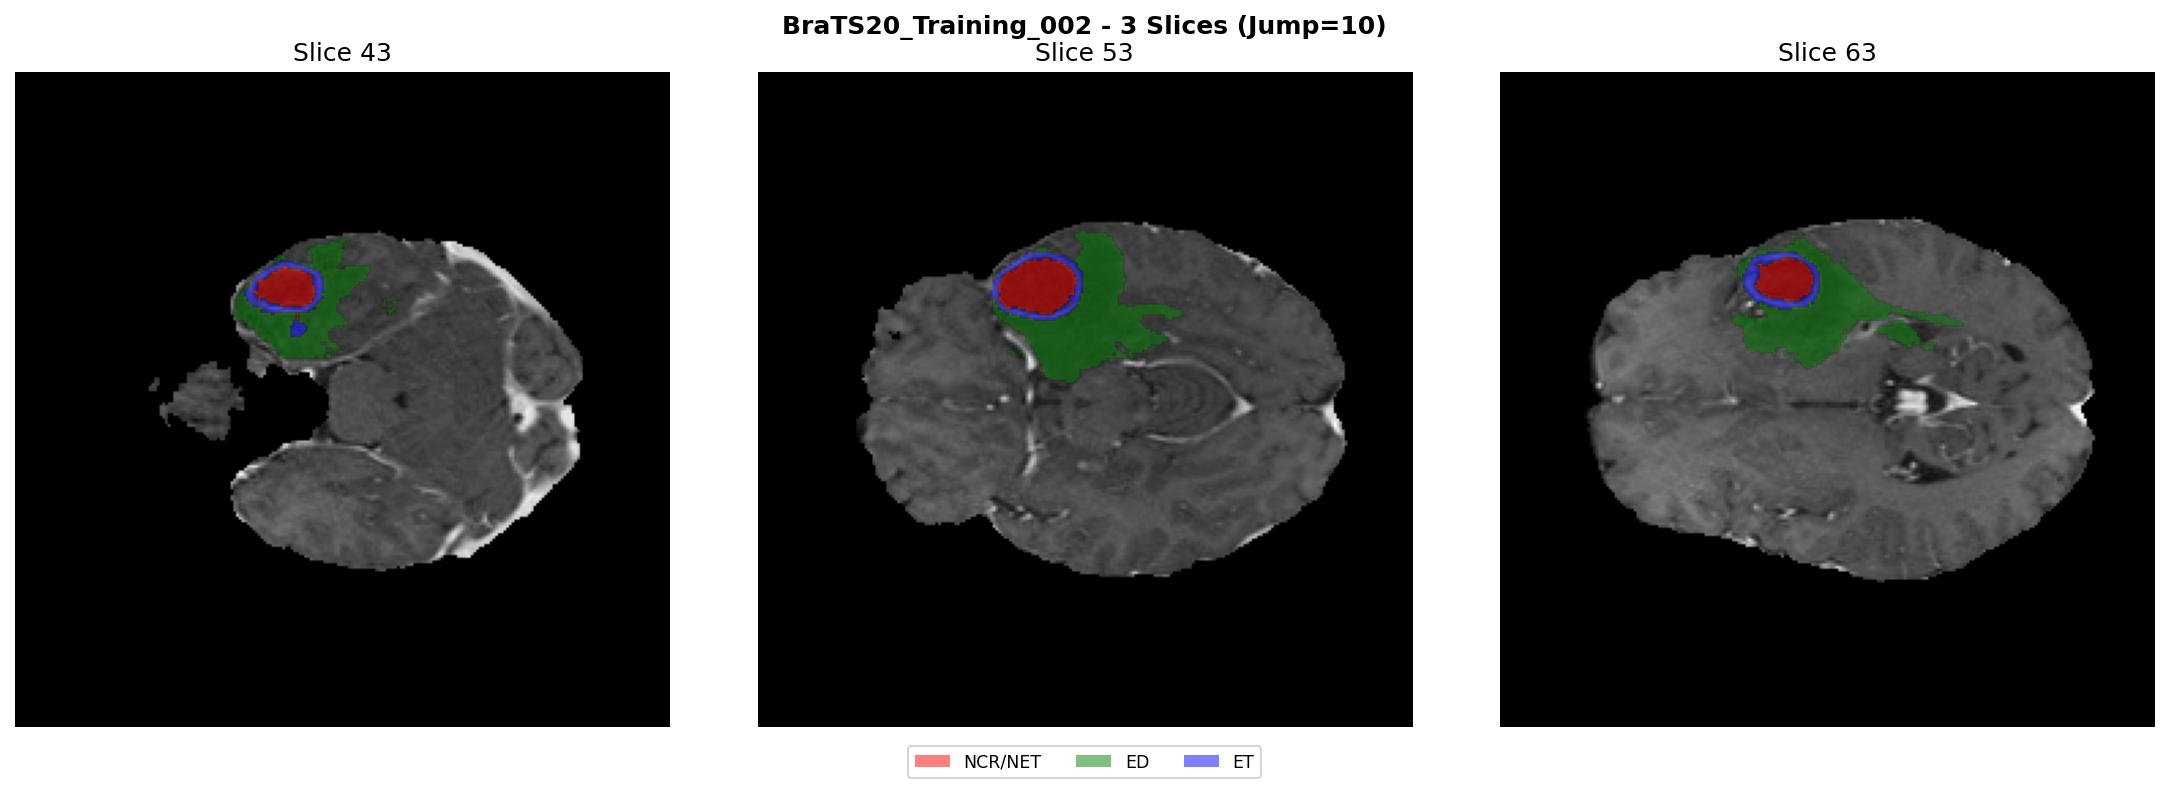


────────────────────────────────────────────────────────────────────────────────────────────────────
🎯 GROUND TRUTH (Expert Annotation):
────────────────────────────────────────────────────────────────────────────────────────────────────
The lesion area is in the right frontal and parietal lobes with a mixed pattern of high and low signals with speckled high signal regions. Edema is mainly observed in the right parietal lobe, partially extending to the frontal lobe, presenting as high signal, indicating significant tissue swelling around the lesion. Necrosis is within the lesions of the right parietal and frontal lobes, appearing as mixed, with alternating high and low signal regions. Ventricular compression is seen in the lateral ventricles with significant compressive effects on the brain tissue and ventricles.

────────────────────────────────────────────────────────────────────────────────────────────────────
🤖 MODEL RESPONSES:
─────────────────────────────────────────────────────

Model,Response,Length,Time (s)
original,"Based on the provided MRI scan, here's an analysis of the identifiable regions and structures: * **Brain:** The central structure is the brain, which is visible in all three images. * **Edema (ED):** There appears to be a large area of edema (swelling) in the right hemisphere of the brain, indicated by the green color. * **Necrosis (NET):** There is also a large area of necrosis (tissue death) in the right hemisphere of the brain, indicated by the red color. * **Tumor (ET):** There is a large area of tumor in the right hemisphere of the brain, indicated by the blue color. The images show a possible brain tumor with associated edema and necrosis. **Disclaimer:** I am an AI and cannot provide medical diagnoses. A qualified medical professional must interpret the scan and provide a diagnosis.",811,9.700000
r1_alpha2_epochs1,"The MRI slice shows: The lesion area is in the right frontal lobe, right temporal lobe and parts of the parietal lobe with a mix of heterogeneous high and low signals, along with spotty high signal regions. Edema is mainly concentrated in the right frontal and temporal lobes, with the extent of edema being relatively extensive. Ventricular compression is not apparent, but the ventricles are slightly compressed.",414,4.310000
r1_alpha4_epochs1,"The MRI slice demonstrates: The lesion area is in the left frontal and parietal lobes with a mixture of high and low signals, as well as patchy high signal areas. Edema is observed around the lesion areas in the left frontal and parietal lobes, indicating significant swelling of the surrounding tissue. Ventricular compression is observed with the left lateral ventricle compressed and deformed, indicating the lesion is causing pressure on the ventricle.",456,4.420000
r1_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the right frontal and temporal lobes with a mix of high and low signals with patchy high signal areas. Edema is primarily observed in the right frontal and temporal lobes, presenting as high signal areas, indicating significant swelling of the tissue surrounding the lesions. Necrosis is indicated by areas of low signal in the right frontal and temporal lobes, with uneven signal intensity and mixed signals. Ventricular compression is observed in the right ventricle, which appears compressed and deformed.",558,5.530000
r4_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the right frontal lobe with a mixture of heterogeneous high and low signals, with spotty high-signal areas. Edema is significant, primarily concentrated in the right frontal lobe, indicating swelling in the surrounding tissues. Ventricular compression is observed, with the right ventricle compressed and deformed. Necrosis is possible, with low-signal areas in the right frontal lobe suggesting potential necrosis.",465,4.720000
r16_alpha16_epochs2,"Analysis of this brain MRI reveals: The lesion area is in the right frontal lobe with a mixture of heterogeneous high and low signals, with spotted high signal regions suggesting the presence of multiple lesions. Edema is significant, mainly observed in the right frontal lobe, with a large area of swelling indicating a severe degree of tissue swelling. Necrosis is present in the right frontal lobe, appearing as low signal areas with mixed signal intensity, scattered within the lesion region. Ventricular compression is observed, with the right lateral ventricle being compressed and deformed.",597,5.830000



────────────────────────────────────────────────────────────────────────────────────────────────────
📊 QUICK COMPARISON:
────────────────────────────────────────────────────────────────────────────────────────────────────
Ground truth length: 586 characters
Average model response length: 550 characters
Response length range: 414-811 characters
Average generation time: 5.75 seconds
────────────────────────────────────────────────────────────────────────────────────────────────────



In [27]:
compare_brain_mri_with_ground_truth('Brain MRI - Three Slices')

#### Five Slices Brain MRI vs Ground Truth


BRAIN MRI ANALYSIS: Brain MRI - Five Slices



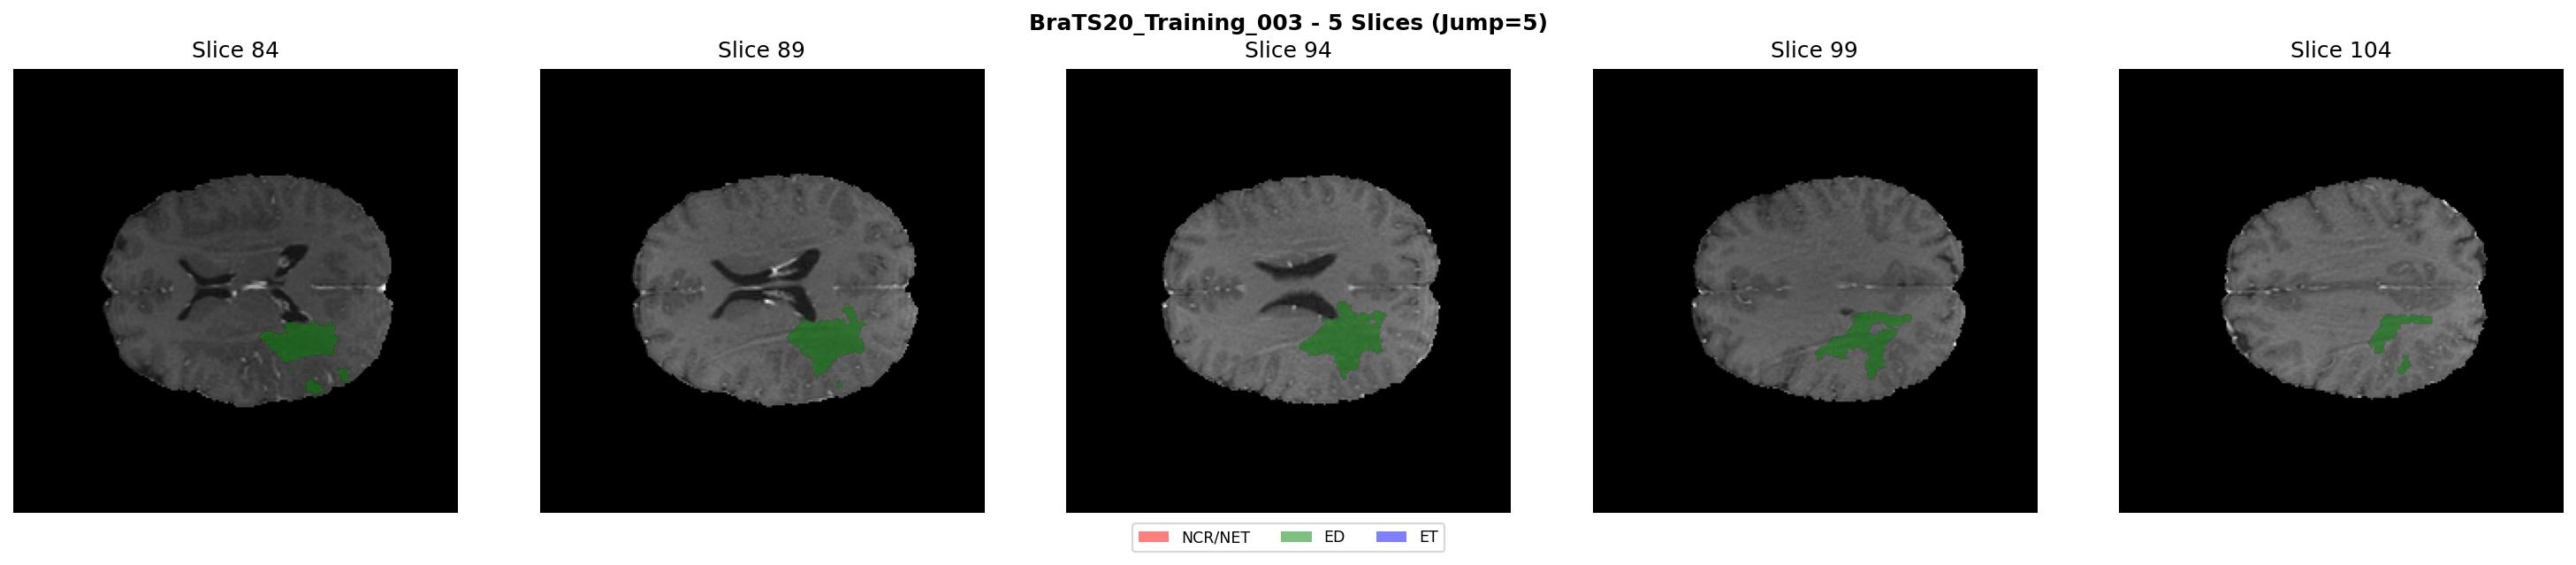


────────────────────────────────────────────────────────────────────────────────────────────────────
🎯 GROUND TRUTH (Expert Annotation):
────────────────────────────────────────────────────────────────────────────────────────────────────
The lesion area is in the right frontal and parietal lobes with a mixed pattern of high and low signals with speckled high signal regions. Edema is mainly observed in the right parietal lobe, partially extending to the frontal lobe, presenting as high signal, indicating significant tissue swelling around the lesion. Necrosis is within the lesions of the right parietal and frontal lobes, appearing as mixed, with alternating high and low signal regions. Ventricular compression is seen in the lateral ventricles with significant compressive effects on the brain tissue and ventricles.

────────────────────────────────────────────────────────────────────────────────────────────────────
🤖 MODEL RESPONSES:
─────────────────────────────────────────────────────

Model,Response,Length,Time (s)
original,"Based on the provided image, here's an analysis of the brain structures and regions I can identify: * **Brain (Gray Matter):** The overall structure of the brain is visible, with the gray matter (outer layer) appearing in shades of green and red. This is the most prominent structure. * **Brain (White Matter):** The white matter (inner layer) is represented by the red color. * **CSF (Cerebrospinal Fluid):** The cerebrospinal fluid (CSF) is likely represented by the blue color, it is not clearly visible in this image. * **NC, CN, and CT:** The image is likely a representation of a brain MRI, and the different colors are likely used to represent different tissues or structures. * NC (likely Neurons): Representing the neurons of the brain. * CN (likely Cortical Neurons): Representing the cortical neurons. * CT",844,10.320000
r1_alpha2_epochs1,"The MRI slice series demonstrates: The lesion area is in the right frontal and parietal lobes with a mixture of heterogeneous high and low signals, and a few scattered high-signal areas. Edema is mainly concentrated in the right frontal and parietal lobes, with a relatively high degree of signal intensity, indicating a significant degree of edema. Ventricular compression is not observed.",390,3.980000
r1_alpha4_epochs1,"The MRI slices demonstrate: The lesion area is in the left frontal and temporal lobes with a mixture of high and low signals, as well as spotty high signal areas. Edema is observed in the left frontal and temporal lobes with high signal intensity, indicating a significant degree of swelling in the surrounding tissues. Ventricular compression is observed with the left ventricle being noticeably deformed, with the right ventricle also showing some compression.",462,4.600000
r1_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the left frontal lobe with a mixture of heterogeneous high and low signals and speckled high-signal areas. Edema is significant, mainly concentrated in the left frontal lobe, extending into parts of the parietal lobe. Ventricular compression is observed, with the left ventricle noticeably compressed and reduced in size.",371,3.790000
r4_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the left parietal lobe with a mix of heterogeneous high and low signals, along with speckled high-signal regions. The lesion area is also in the frontal lobe, with mixed high and low signals and patchy high-signal regions. Ventricular compression is observed in the left lateral ventricle, which appears compressed and deformed. Edema is significant in the left parietal lobe and less pronounced in the frontal lobe, characterized by high signals. Necrosis is observed in the left parietal lobe with low signals and a mixed appearance.",585,6.120000
r16_alpha16_epochs2,"Analysis of this brain MRI reveals: The lesion area is in the left parietal lobe with a mix of heterogeneous high and low signals, with spotty high-signal regions. Edema is significant in the left parietal lobe area, suggesting marked swelling of the tissue surrounding the lesion. Necrosis is indicated by large low-signal regions in the left parietal lobe, with mixed high and low signals, suggesting scattered necrotic tissue. Ventricular compression is observed with the left lateral ventricle appearing compressed and deformed.",532,5.300000



────────────────────────────────────────────────────────────────────────────────────────────────────
📊 QUICK COMPARISON:
────────────────────────────────────────────────────────────────────────────────────────────────────
Ground truth length: 586 characters
Average model response length: 531 characters
Response length range: 371-844 characters
Average generation time: 5.68 seconds
────────────────────────────────────────────────────────────────────────────────────────────────────



In [28]:
compare_brain_mri_with_ground_truth('Brain MRI - Five Slices')

---
## 📝 Text Questions

Comparison of model responses to simple text questions.

In [29]:
# Helper function to display text question comparison
def show_text_question(category):
    subset = df[(df['type'] == 'text') & (df['category'] == category)]
    
    if len(subset) == 0:
        print(f"No results for: {category}")
        return
    
    prompt = subset.iloc[0]['prompt']
    
    print(f"\n{'='*100}")
    print(f"QUESTION: {prompt}")
    print(f"Category: {category}")
    print(f"{'='*100}\n")
    
    # Create comparison table
    comparison = subset[['model', 'response', 'length', 'time']].copy()
    comparison.columns = ['Model', 'Response', 'Length (chars)', 'Time (s)']
    
    display(comparison.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap'
    }).hide(axis='index'))

### Question 1: Greeting

In [30]:
show_text_question('Greeting')


QUESTION: Hello
Category: Greeting



Model,Response,Length (chars),Time (s)
original,Hello! How can I help you today?,32,4.750000
r1_alpha2_epochs1,Hello! How can I help you today?,32,0.630000
r1_alpha4_epochs1,Hello! How can I help you today?,32,0.620000
r1_alpha4_epochs2,Hello! How can I help you today?,32,0.640000
r4_alpha4_epochs2,Hello! How can I help you today?,32,0.630000
r16_alpha16_epochs2,Hello! How can I help you today?,32,0.630000


### Question 2: General Knowledge

In [31]:
show_text_question('General Knowledge')


QUESTION: What is the capital of France?
Category: General Knowledge



Model,Response,Length (chars),Time (s)
original,The capital of France is **Paris**.,35,0.560000
r1_alpha2_epochs1,The capital of France is Paris.,31,0.520000
r1_alpha4_epochs1,The capital of France is Paris.,31,0.510000
r1_alpha4_epochs2,The capital of France is Paris.,31,0.530000
r4_alpha4_epochs2,The capital of France is Paris.,31,0.510000
r16_alpha16_epochs2,The capital of France is Paris.,31,0.510000


### Question 3: Math

In [32]:
show_text_question('Math')


QUESTION: What is 2 + 2?
Category: Math



Model,Response,Length (chars),Time (s)
original,2 + 2 = 4,9,0.520000
r1_alpha2_epochs1,2 + 2 = 4,9,0.510000
r1_alpha4_epochs1,2 + 2 = 4,9,0.510000
r1_alpha4_epochs2,2 + 2 = 4,9,0.520000
r4_alpha4_epochs2,2 + 2 = 4,9,0.520000
r16_alpha16_epochs2,2 + 2 = 4,9,0.510000


### Question 4: Identity

In [33]:
show_text_question('Identity')


QUESTION: Who are you?
Category: Identity



Model,Response,Length (chars),Time (s)
original,"I am Gemma, an open-weights AI . I am a large language trained by Google DeepMind.",83,1.320000
r1_alpha2_epochs1,"I am Gemma, a large language trained by Google DeepMind.",57,0.880000
r1_alpha4_epochs1,"I am Gemma, a large language trained by Google DeepMind.",57,0.840000
r1_alpha4_epochs2,"I am Gemma, an open-weights AI . I am a large language trained by Google DeepMind.",83,1.390000
r4_alpha4_epochs2,"I am Gemma, an open-weights AI . I am a large language trained by Google DeepMind.",83,1.380000
r16_alpha16_epochs2,"I am Gemma, an open-weights AI . I am a large language trained by Google DeepMind.",83,1.350000


### Question 5: Medical Knowledge

In [34]:
show_text_question('Medical Knowledge')


QUESTION: What is a brain tumor?
Category: Medical Knowledge



Model,Response,Length (chars),Time (s)
original,"A brain tumor is a mass of abnormal cells that grows in the brain. These cells can be cancerous (malignant) or non-cancerous (benign). While the term ""brain tumor"" is often used to refer to cancerous tumors, it's important to remember that many brain tumors are not cancerous and are therefore not life-threatening. Here's a more detailed breakdown: * **What it is:** An abnormal growth of cells in the brain. * **Where it grows:** Within the brain tissue itself or near the brain. * **Types:** * **Benign:** Non-cancerous. They tend to grow slowly, stay localized, and are less likely to spread to other parts of the body. However, even benign tumors can cause problems by pressing on surrounding brain tissue, nerves, or blood vessels. * **Malignant:** Cancerous. They grow rapidly, can spread to other parts of the brain",843,10.400000
r1_alpha2_epochs1,"A brain tumor is an abnormal growth of cells in the brain. These cells can be: * **Non-cancerous (benign):** Grow slowly and typically stay localized, meaning they don't spread to other parts of the brain. However, they can still cause pressure and damage to surrounding tissues. * **Cancerous (malignant):** Grow rapidly and can invade nearby brain tissue and spread to other areas of the brain or even distant parts of the body (metastasis).",448,5.510000
r1_alpha4_epochs1,"A brain tumor is an abnormal growth of cells in the brain. These cells can be: * **Non-cancerous (benign):** These tumors grow slowly and tend to remain localized. However, they can still cause problems by pressing on nearby brain tissue or nerves. * **Cancerous (malignant):** These tumors grow rapidly and can spread to other parts of the brain or other organs in the body (metastasis).",393,4.950000
r1_alpha4_epochs2,"A brain tumor is a group of abnormal cells (tumor cells) that grow in the brain. These tumors can be: * **Benign:** Non-cancerous, slow-growing, and often remain localized. * **Malignant:** Cancerous, fast-growing, and can spread to nearby tissues and other parts of the brain. * **Mixed:** A combination of both benign and malignant features. Brain tumors can arise from various parts of the brain, including the cerebral hemispheres, the brainstem, and the cerebellum. They may also occur in the meninges (the membranes surrounding the brain) or the brain tissue itself.",580,7.320000
r4_alpha4_epochs2,"A brain tumor is a mass of abnormal cells within the brain. These tumors can be: * **Benign:** Non-cancerous, slow-growing, and typically remain localized. However, they can still cause problems by pressing on nearby brain tissue and structures. * **Malignant:** Cancerous, characterized by rapid growth, invasion into surrounding tissues, and potential for metastasis (spreading to other parts of the brain or distant organs). * **Mixed:** Contain a combination of both benign and malignant tumor components.",516,5.940000
r16_alpha16_epochs2,"A brain tumor is a growth of abnormal cells in the brain. These cells can be cancerous (malignant) or non-cancerous (benign), and they can affect brain tissue, blood vessels, and nerves. Brain tumors can cause a wide range of symptoms depending on their location and size, including headaches, seizures, vision problems, weakness, and changes in personality or behavior.",370,4.160000


---
## 🖼️ Image Questions

Each image is shown followed by a table comparing all model responses.

In [35]:
# Helper function to display image question comparison
def show_image_question(category):
    subset = df[(df['type'] == 'image') & (df['category'] == category)]
    
    if len(subset) == 0:
        print(f"No results for: {category}")
        return
    
    row = subset.iloc[0]
    prompt = row['prompt']
    image_path = row['image']
    
    print(f"\n{'='*100}")
    print(f"CATEGORY: {category}")
    print(f"QUESTION: {prompt}")
    print(f"{'='*100}\n")
    
    # Display image
    if image_path:
        display(Image(filename=image_path, width=500))
    
    print(f"\n{'─'*100}")
    print("MODEL RESPONSES:")
    print(f"{'─'*100}\n")
    
    # Create comparison table
    comparison = subset[['model', 'response', 'length', 'time']].copy()
    comparison.columns = ['Model', 'Response', 'Length (chars)', 'Time (s)']
    
    display(comparison.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'vertical-align': 'top'
    }).hide(axis='index'))

### Image 4: Medical Image - Chest X-ray


CATEGORY: Medical Image - Chest X-ray
QUESTION: What do you see in this image? Describe it in detail.



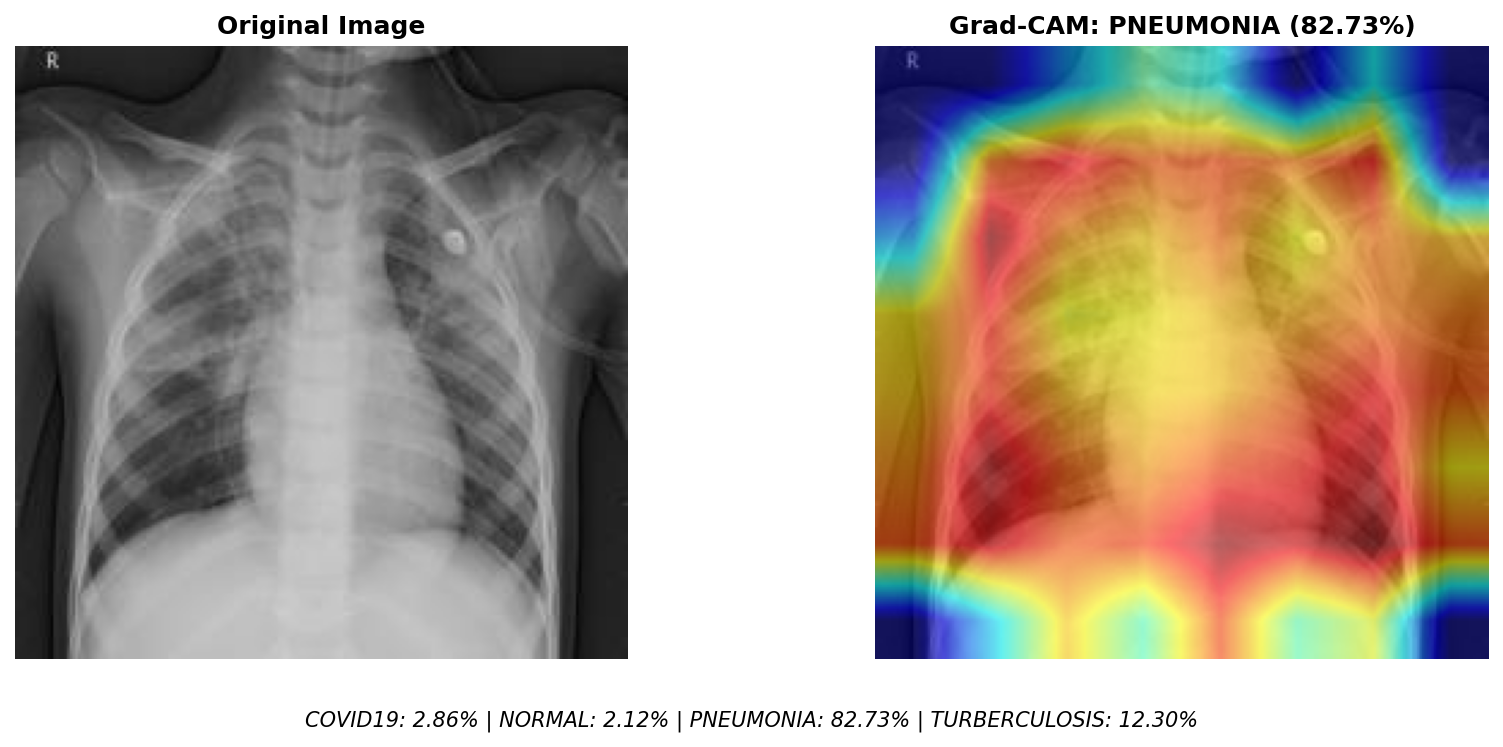


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"Based on the image provided, here's a detailed description: **Overall Impression:** The image shows a chest X-ray, with the left side (on the right side of the image) appearing significantly different from the right side. The left side exhibits a much more intense and widespread pattern of red/orange/yellow, while the right side has a more subdued pattern. **Left Side (Pneumonia/Tuberculosis):** * **Intense Red/Orange/Yellow Pattern:** The left side of the chest shows a very strong, diffuse pattern of red, orange, and yellow. This suggests significant inflammation or infection in the lung tissue. * **Possible Consolidation:** The pattern could be indicative of consolidation, which is a process where the air spaces in the lung are filled with fluid or inflammatory cells. This can be seen in conditions like pneumonia or tuberculosis. * **High Probability of Pneumonia/Tuberculosis:** The ""Grad-CAM: P",919,10.310000
r1_alpha2_epochs1,"The MRI slice shows: The left lung presents with patchy high-signal regions, mainly in the upper and lower lobes, with some areas appearing as high-signal regions. The right lung is relatively normal, with only minor high-signal regions in the upper lobe, appearing as scattered spots. Edema is observed in the left lung, particularly in the upper and lower lobes, with a high signal intensity suggesting significant tissue swelling. Ventricular compression is not observed, with the ventricles appearing normal in size and shape. The heart size is within the normal range. The lesion distribution is in the left lung, with areas of high signal intensity suggesting inflammation and edema.",689,7.120000
r1_alpha4_epochs1,"The MRI slice shows: The lesion area is in the left lung with a mix of high and low signals with speckled high-signal regions and scattered low-signal areas. Edema is significant in the left lung, with a distinct high signal indicating edema, mainly concentrated in the central part of the left lung and surrounding areas. The left lung exhibits mixed signal intensity with a combination of high and low signal areas, suggesting a complex pattern of lesions. Ventricular compression is evident, with the left ventricle appearing compressed and deformed. The right lung shows relatively normal tissue distribution with low signal intensity.",639,6.400000
r1_alpha4_epochs2,"The MRI slice demonstrates: The lesion area is in the left lung, particularly in the left lower lobe, with mixed signals of varying intensity and patchy high-signal areas, indicating multiple lesions. Edema is observed in the left lung tissue surrounding the lesions, with significant swelling of the tissue. Ventricular compression is noted in the left lung, with signs of compression on the left lung tissue and surrounding structures.",437,4.550000
r4_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the left lung, primarily in the left lung, with a mixture of high and low signals, and patchy high signal regions, suggesting multiple lesions. Edema is significant, mainly concentrated in the left lung, with a large area of edema. The lesion areas in the left lung are relatively concentrated, with some scattered high-signal lesions. The edema area is relatively extensive, covering a large portion of the left lung. Ventricular compression is not observed. The right lung shows no significant abnormalities.",560,5.970000
r16_alpha16_epochs2,"This is a single axial slice through the chest. The left lung shows a large area of high signal intensity, suggesting extensive edema and heterogeneous high signal regions, particularly in the left lung field. The right lung shows a smaller high signal region, indicating a localized area of edema, relatively concentrated in the upper lobe. The mediastinum is mildly expanded, suggesting a possible increase in mediastinal pressure. The heart is normal in size and shape. Ventricular compression is not observed. The overall appearance sugge

In [39]:
show_image_question('Medical Image - Chest X-ray')

### Image 5: Medical Image - Brain Scan


CATEGORY: Medical Image - Brain Scan
QUESTION: What do you see in this image? Describe it in detail.



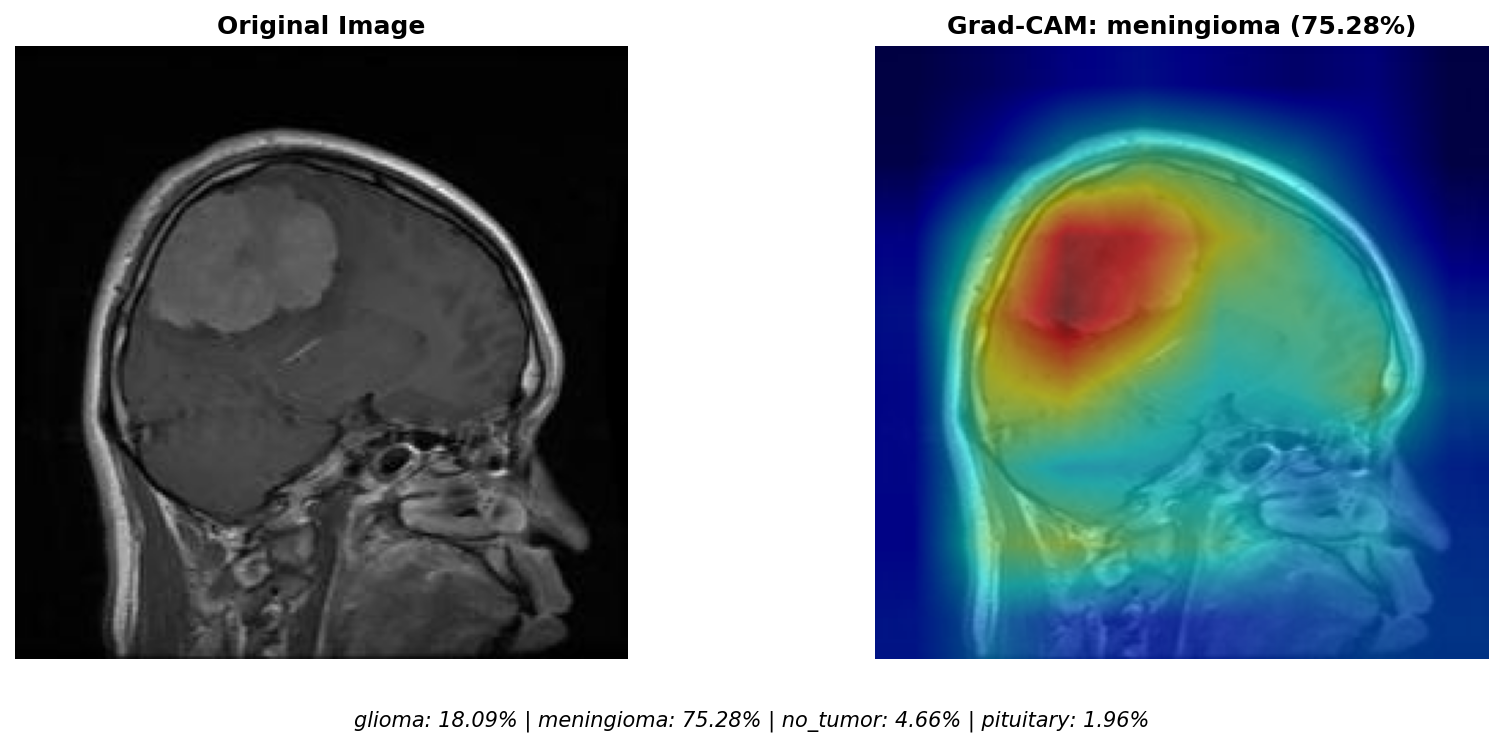


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"Okay, I'm looking at an MRI image of the brain. Here's a detailed description: **Overall Impression:** The image shows a brain scan, likely an axial view (as seen from above). There appears to be a significant abnormality in the right side of the brain, specifically in the area of the meninges. **Key Features:** * **Brain Structure:** The overall shape of the brain is visible, including the cerebral hemispheres, the skull, and the sinuses. * **Abnormality in the Right Side:** The most prominent feature is a large, abnormal area in the right side of the brain. The color coding in the ""Grad-CAM"" image indicates a high concentration of the abnormality in this region. * **Meningioma:** The ""Grad-CAM"" image identifies this area as a ""meningioma."" This is a type of tumor that arises from the meninges, the membranes surrounding the brain and spinal cord",868,10.320000
r1_alpha2_epochs1,"The MRI slice shows: The lesion area is in the right frontal and temporal lobes of the brain with a mix of high and low signals, with a mixture of heterogeneous high and low signal regions and some high-signal areas. Edema is significant in the right frontal and temporal lobes, indicating swelling of the tissue surrounding the lesions. Ventricular compression is observed, particularly in the right ventricle, which is noticeably compressed. Necrosis is suspected in the central part of the right frontal lobe, characterized by low signal intensity.",551,5.620000
r1_alpha4_epochs1,"The MRI slice demonstrates: The lesion area is in the right frontal lobe, right temporal lobe, and right parietal lobe with a mixture of heterogeneous high and low signals, with speckled high-signal areas. Edema is present in the right frontal and temporal lobes, with the extent of edema relatively high. Ventricular compression is observed with the right lateral ventricle compressed and deformed. The lesion area is significant, affecting a large portion of the right cerebral hemisphere.",491,4.990000
r1_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the right frontal lobe, right temporal lobe, and right parietal lobe with a mix of heterogeneous high and low signals with patchy high signal regions, indicating multiple lesions. Edema is mainly concentrated in the right frontal and temporal lobes, with a relatively large extent, indicating significant swelling in the tissue surrounding the lesions. Ventricular compression is evident with the right lateral ventricle compressed and deformed, suggesting that the lesions exert a certain degree of pressure on the ventricular system. Necrosis is suggested by low signal areas in the right frontal and temporal lobes, with uneven signal intensity, indicating possible necrotic tissue.",735,6.880000
r4_alpha4_epochs2,"The MRI slices demonstrate: The lesion area is in the right frontal lobe, right temporal lobe, and right parietal lobe with mixed high and low signals and patchy high signal areas. Edema is significant, primarily observed in the right frontal lobe, right temporal lobe, and right parietal lobe, suggesting significant swelling of the tissues surrounding the lesions. Ventricular compression is observed, particularly in the right ventricle, which shows some deformation and compression, indicating a certain degree of compression on the ventricular system by the lesions. Necrosis is suggested by some low-signal areas in the right frontal lobe and right parietal lobe, with a mixed signal intensity that is relatively low and scattered, suggesting possible necrosis in these areas.",782,7.660000
r16_alpha16_epochs2,"The MRI slices demonstrate: The lesion area is in the right frontal and parietal lobes with heterogeneous high and low signal intensity, along with speckled high signal regions. Edema is significant, primarily observed in the right frontal and parietal lobes, with a large extent of edema indicating considerable swelling in the surrounding tissues. Ventr

In [40]:
show_image_question('Medical Image - Brain Scan')

### Image 6: Medical Image - Tissue Sample


CATEGORY: Medical Image - Tissue Sample
QUESTION: What do you see in this image? Describe it in detail.



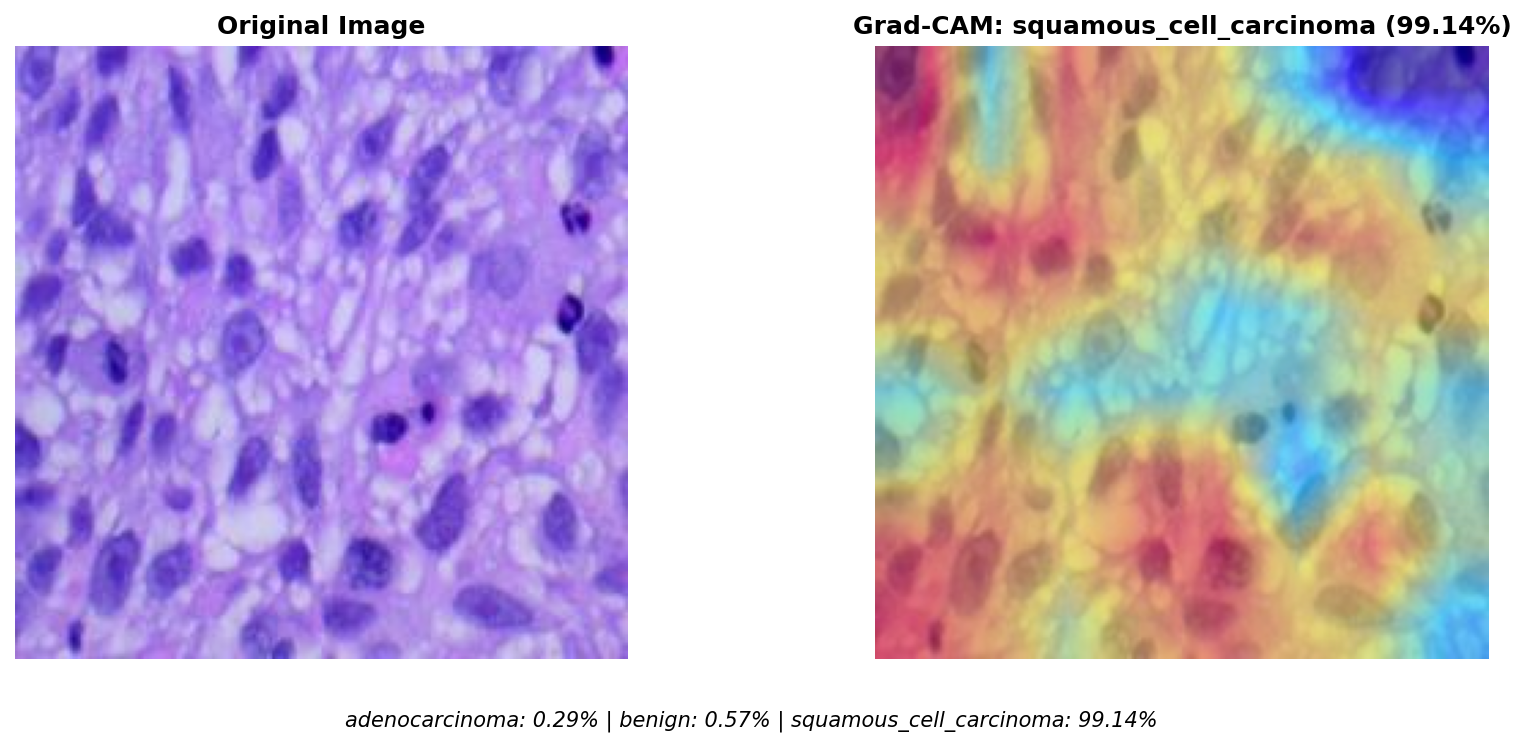


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"Here's a detailed description of the image, based on the information provided: **Original Image (Left):** * **Appearance:** The image appears to be a microscopic view of tissue, likely a biopsy sample. The colors are vibrant, and there are distinct structures visible. * **Cellular Features:** There are cells of varying shapes and sizes present. Some cells appear to be more densely packed than others. * **Tissue Structure:** The image suggests a complex tissue architecture with different cell types and potentially some degree of organization. * **Coloration:** The tissue is stained, likely with a dye that highlights specific cellular components. The color scheme is used to differentiate between different cell types or structures. **Grad-CAM (Right):** * **Appearance:** The image on the right is a heatmap, a visual representation of the Grad-CAM algorithm. This algorithm is used to highlight the regions of the input image that are most important for the",979,10.380000
r1_alpha2_epochs1,"The MRI slice shows: The lesion area is in the right lobe of the brain with a mix of heterogeneous high and low signals, with some spotted high signal areas. Edema is observed in the surrounding brain tissue, indicating significant swelling. Ventricular compression is observed as the lesion area compresses the ventricles, causing them to appear smaller and more irregular.",374,3.860000
r1_alpha4_epochs1,"The MRI slice shows: The lesion area is in the left side of the brain with a mix of heterogeneous high and low signals, along with speckled high-signal regions. Edema is significant, with the surrounding brain tissue showing a diffuse high signal, suggesting considerable swelling. Necrosis is observed with low signals and patchy high-signal regions, particularly concentrated in the left side of the brain. Ventricular compression is observed, with the left ventricle compressed and deformed.",494,5.100000
r1_alpha4_epochs2,"This is a single axial slice through the brain. The lesion area is in the right side of the brain with a mixture of heterogeneous high and low signals, with some regions displaying speckled high signal areas. Edema is observed with significant swelling in the tissues surrounding the lesion, indicating a severe inflammatory response. Necrosis is observed with some areas showing distinctly low signal intensity, suggesting the presence of necrotic tissue, scattered within the high signal areas. Ventricular compression is observed with the right lateral ventricle compressed and deformed, indicating significant pressure on the ventricular system.",649,6.000000
r4_alpha4_epochs2,"The MRI slice demonstrates: The lesion area is in the right parietal lobe with heterogeneous mixed signals, including spotted high-signal areas. Edema is prominent, mainly observed in the right parietal lobe, suggesting significant tissue swelling and extensive extent of the lesion area. Necrosis is indicated by low-signal regions within the high-signal areas, concentrated in the central part of the lesion. Ventricular compression is observed with the right lateral ventricle compressed and deformed, resulting in reduced volume.",533,5.260000
r16_alpha16_epochs2,"The histology image shows: The tumor area is in the right frontal lobe of the brain with a mix of heterogeneous high and low signals, with spotted high-signal areas suggesting the presence of multiple lesions. Edema is significant in the right frontal lobe, indicating a large extent of tissue swelling. Necrosis is observed with low-signal regions, primarily concentrated in the right frontal lobe, presenting as unevenly distributed low signals. Ventricular compression is evident as the right lateral ventricle is compressed and deformed.",541,5.380000


In [41]:
show_image_question('Medical Image - Tissue Sample')

### Image 7: Medical Image - Blood Cells


CATEGORY: Medical Image - Blood Cells
QUESTION: What do you see in this image? Describe it in detail.



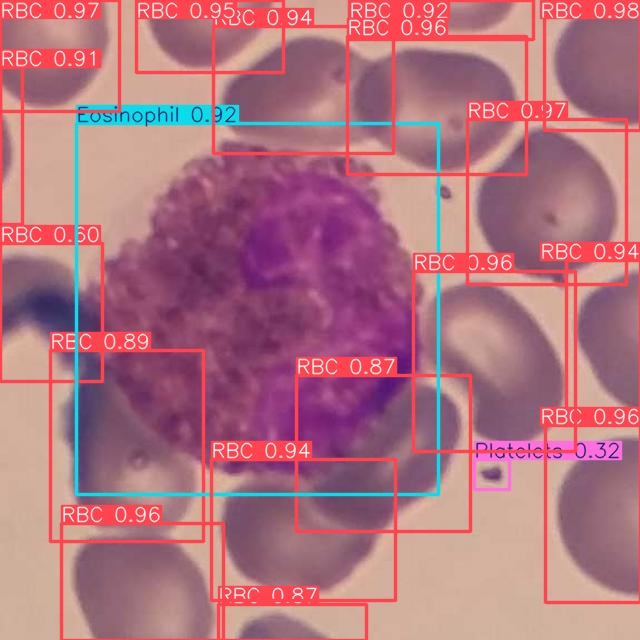


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"Okay, I've analyzed the image. Here's a detailed description: **Overall Impression:** The image appears to be a blood smear, likely stained with a Wright's stain. It shows a variety of blood cells, with some cells highlighted in red, others in blue, and some in purple. The cells are likely being analyzed for their characteristics, such as size, shape, and internal structure. **Specific Cells:** * **Eosinophils:** The image shows several cells that appear to be eosinophils. They are characterized by their bilobed nucleus (two lobes) and their large, pale-pink cytoplasm. In the image, they are highlighted in red. * **RBCs (Red Blood Cells):** There are many red blood cells present, and they are highlighted in red. * **Platelets:** The image shows several platelets, which are small, anucleate (without a nucleus) cells. They are highlighted",858,10.300000
r1_alpha2_epochs1,"This is a high-resolution microscopic image of a blood sample. The predominant feature is a large, irregularly shaped, highly heterogeneous tumor area in the center of the image. It exhibits a mix of colors with high variability and patchy signals. Edges are irregular and blurred. Scattered throughout the image are multiple spots of varying size and intensity, indicating the presence of multiple tumor regions. The tumor area is located in the area between the red and blue channels, with the high-intensity areas indicating regions with a higher concentration of tumor cells. Scattered in the image are numerous red and blue spots, representing individual cells, with some cells showing irregular shapes and high concentrations of red and blue signals. Scattered among these cells are some small areas of higher signal intensity, suggesting the presence of tumor necrosis. The distribution of these cells is uneven, with some areas having a high concentration of cells and others having a lower concentration.",1013,9.630000
r1_alpha4_epochs1,"The tissue sample exhibits a mix of high and low signals with a heterogeneous signal distribution. Notably, a large area in the center of the sample shows high signal intensity, suggesting potential necrosis or tumor areas. Edges are not well defined, with a mix of high and low signals, indicating the presence of multiple regions with varying degrees of signal intensity. The surrounding tissues are characterized by a mix of low and high signals, with some regions showing high signal intensity, possibly indicating inflammation or edema. The presence of cells is observed, with some appearing as distinct regions of high signal intensity, potentially indicating the presence of tumor cells. The sample is relatively uniform in size, with dimensions of approximately 200x150x150 microns.",790,8.070000
r1_alpha4_epochs2,"The MRI slice demonstrates: The central region shows a large, heterogeneous area of high signal intensity, with spotted high-signal regions and irregular boundaries. Edges of the lesions are not clearly defined. The surrounding tissues show mild swelling, with the edema extending to some adjacent tissues. Ventricular compression is not observed.",347,3.510000
r4_alpha4_epochs2,"The comprehensive analysis of this brain scan reveals: The lesion area is in the left frontal lobe with a mixture of high and low signals with spotty high signal areas. Edema is observed around the lesion area in the left frontal lobe, with the edema signal primarily concentrated near the lesion center, indicating a significant degree of swelling in the surrounding tissues. Necrosis is suggested by low signal areas within the lesion, particularly in the central region of the lesion, with a mix of low and iso-signals, indicating potential necrotic tissue. Ventricular compression is not observed in the brain tissue or ventricles.",635,6.500000
r16_alpha16_epochs2,"This image shows: The central region displays a high-signal lesion area with a mixed signal intensity pattern and patchy high-signal areas. Edge

In [42]:
show_image_question('Medical Image - Blood Cells')

### Image 8: Medical Image - Breast Mammogram


CATEGORY: Medical Image - Breast Mammogram
QUESTION: What do you see in this image? Describe it in detail.



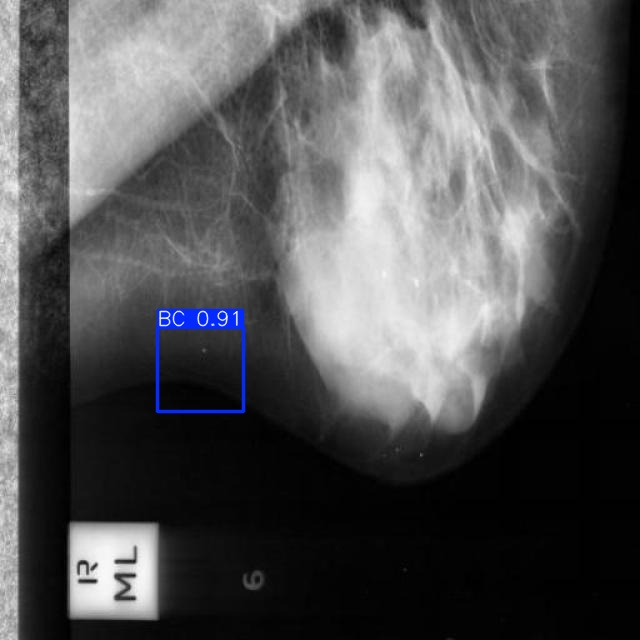


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"Based on the image provided, here's a detailed description: **Overall Impression:** The image is a chest X-ray. It shows the bones of the rib cage, lungs, and heart. The image is labeled with the patient's ID, the image number, and a series of numbers (likely indicating the exposure voltage and current). **Key Features:** * **Ribs:** The ribs are clearly visible, forming the bony framework of the chest. * **Lungs:** The lungs appear as the darker areas on either side of the chest. The lung markings are visible, suggesting the presence of air within the lungs. * **Heart:** The heart is located in the center of the chest, slightly to the left. * **Identification:** A specific area of interest, a nodule, is identified and labeled as ""BC 0.91"". This indicates a nodule of 0.91 cm in size.",806,10.280000
r1_alpha2_epochs1,"This is a single axial slice of a breast MRI. The lesion area is in the central part of the right breast, with heterogeneous signal intensity and spot-like high-signal areas. Edema is observed around the lesion, appearing as a high signal region surrounding the central lesion area, indicating possible edema. Necrosis is observed as low-signal regions with a speckled appearance within the lesion, indicating possible necrotic areas. Ventricular compression is not apparent.",475,4.920000
r1_alpha4_epochs1,"The MRI slice shows: The lesion area is in the right breast, with a heterogeneous signal intensity, with areas of high signal and low signal. Edges are irregular, with some clear and some blurred, indicating a complex lesion pattern. The lesion is in the central and peripheral parts of the right breast, with mixed high and low signals, and some high-signal areas. The surrounding tissue is normal, with relatively uniform signal intensity and no significant changes. The right breast tissue is compressed and deformed.",520,5.500000
r1_alpha4_epochs2,"The MRI slice shows: The lesion area is in the left breast with a heterogeneous signal, presenting a mixed signal of both high and low intensities, and speckled high-signal areas. Edema is primarily observed in the left breast tissue, with significant swelling, extending into the surrounding tissues. Necrosis is mainly located in the central part of the lesion area, showing a low signal, and the distribution is relatively dispersed. Ventricular compression is present, with the left ventricle compressed and deformed, indicating a significant compressive effect of the lesion on the brain tissue.",600,6.060000
r4_alpha4_epochs2,"This axial T1CE brain scan shows: The lesion area is in the left frontal and parietal lobes with mixed signal intensities and spot-like high signal areas. Edema is significant, mainly distributed in the left frontal and parietal lobes, appearing as a diffuse high signal area, indicating a severe degree of swelling. Necrosis is suggested by the presence of multiple mixed high and low signal areas in the left parietal lobe, indicating a mixed signal distribution. Ventricular compression is observed in the left lateral ventricle, which is compressed and deformed, indicating a certain degree of ventricular compression.",622,6.280000
r16_alpha16_epochs2,"This chest X-ray slice shows: The left breast is slightly larger than the right, with heterogeneous high and low signals. The left breast has a large area of high signal, with irregular edges, suggesting possible tumor presence. The right breast shows a small high signal area, potentially indicating a small tumor or metastasis, with unclear boundaries. The mediastinum is mildly widened, suggesting possible lymph node involvement.",433,4.330000


In [43]:
show_image_question('Medical Image - Breast Mammogram')

### Image 9: Medical Image - Bone X-ray


CATEGORY: Medical Image - Bone X-ray
QUESTION: What do you see in this image? Describe it in detail.



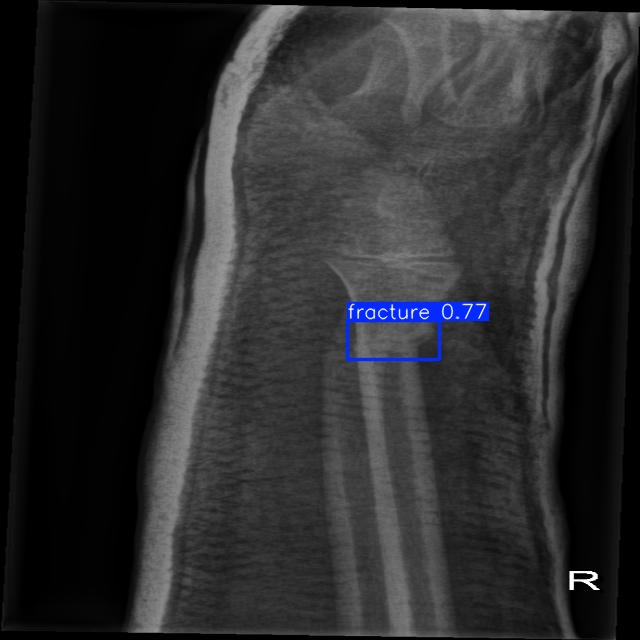


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"Based on the image, I can see the following: * **An X-ray image of the forearm.** The image shows the bones of the forearm, including the radius and ulna. * **A fracture is visible.** A rectangular box highlights an area of the forearm where a fracture is present. The text ""fracture 0.77"" indicates the location and possibly the severity of the fracture, as per the AI's assessment. * **The image is likely from a medical scan.** The presence of a fracture suggests that this is a medical image, possibly taken for diagnostic purposes. In summary, the image shows a forearm X-ray with a visible fracture, and the AI has identified and labeled the fracture location.",674,8.070000
r1_alpha2_epochs1,"The axial MRI slice shows: The left radius bone is severely deformed with a mix of high and low signals. The high signal areas are concentrated in the distal part of the radius, indicating significant tissue damage and possible edema. The low signal areas are in the proximal part of the radius, suggesting possible bone necrosis. The ulna is relatively normal with no obvious abnormalities. The wrist joint is compressed, with the distal part of the radius appearing severely compressed, and the proximal part of the radius showing signs of compression.",554,5.460000
r1_alpha4_epochs1,"The axial MRI slice shows: The left distal radius exhibits a mixed signal area with uneven signal intensity, concentrated in the distal portion of the radius. The cortical bone is deformed, with visible cracks and irregular changes. The medullary cavity shows a complex pattern, with some areas appearing relatively low signal and others showing high signal, indicating the presence of edema. The adjacent proximal and distal parts of the radius show slightly increased signal intensity, indicating possible edema or inflammatory reactions. The distal part of the radius is relatively compressed.",596,5.610000
r1_alpha4_epochs2,"The MRI slice demonstrates: The lesion area is in the distal part of the left femur with a mixture of high and low signals, with spotty high signal areas. Edema is observed in the peripheral region of the lesion with significant signal intensity, indicating a substantial degree of swelling. Necrosis is suggested by the presence of low signal areas within the lesion, particularly at the center of the lesion, where signal intensity is significantly lower than surrounding tissues. Ventricular compression is observed with the left ventricle noticeably compressed, suggesting that the lesion area exerts a compressive effect on the ventricular system.",652,6.370000
r4_alpha4_epochs2,"The MRI slice demonstrates: The lesion area is in the distal part of the left humerus, characterized by mixed signal intensities and patchy high-signal areas, indicating the presence of multiple lesions. The lesion is concentrated in the distal end of the left humerus, with a noticeable area of high signal intensity, suggesting the presence of edema. Edema is significant, with a noticeable increase in the signal intensity surrounding the lesion areas, particularly in the distal part of the left humerus. Necrosis is observed with low-signal regions within the lesion area, suggesting the presence of necrotic tissue, primarily concentrated in the central part of the lesion, with a mixture of low and high signals. Ventricular compression is observed with the left ventricular wall appearing compressed, indicating significant pressure on the left ventricle, resulting in deformation of the ventricular cavity.",915,8.980000
r16_alpha16_epochs2,"The axial T-Slices demonstrate: The lesion area is in the distal part of the left femur with a mixed signal intensity, including high signal, iso-signal, and speckled high signal regions. Edema is primarily observed around the lesion area, extending over a large extent from the distal part of the left femur to the knee joint. The edema signal is relatively uniform and concentrated, suggestin

In [44]:
show_image_question('Medical Image - Bone X-ray')

### Image 10: General Image - Puppies


CATEGORY: General Image - Puppies
QUESTION: What do you see in this image? Describe it in detail.



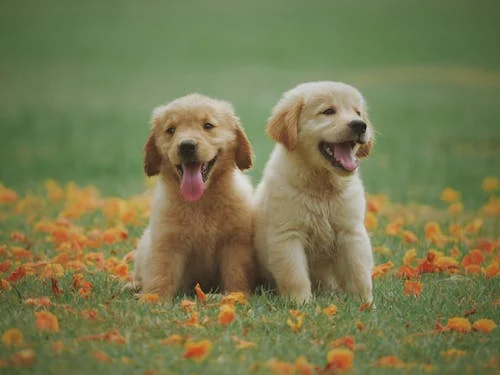


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"The image shows two golden retriever puppies. They are both adorable and appear to be around 6-8 weeks old. Here's a more detailed description: * **Puppies:** The puppies are golden in color, with a light tan or creamish hue. They have a soft, fluffy coat. * **Expression:** Both puppies have wide, open mouths and are smiling, suggesting they are happy and playful. Their eyes are bright and alert. * **Setting:** The puppies are standing on a lush green lawn covered with colorful flowers. The background is blurred, but it appears to be a sunny outdoor setting. * **Overall Impression:** The image evokes a sense of joy, innocence, and the beauty of nature. It's a heartwarming scene that would likely bring a smile to anyone's face.",746,9.110000
r1_alpha2_epochs1,"This is a heartwarming photo of two golden retriever puppies in a field of colorful flowers. The puppies are side-by-side, with one slightly in front of the other. They have a playful, happy expression with their tongues slightly out and their eyes focused on the viewer. The background is a vibrant mix of red, orange, and yellow flowers, suggesting a sunny and cheerful day. The lighting is soft and natural, enhancing the overall warm and inviting atmosphere of the image.",475,5.170000
r1_alpha4_epochs1,"The image shows two golden retriever puppies playing in a field of wildflowers. The puppies are of similar size and have a mix of brown and cream colors in their fur. They are actively engaged with each other, exhibiting playful behavior with their mouths open and tongues sticking out. The background is a vibrant green meadow filled with various types of flowers, including red, yellow, and white blooms. The sky is a bright blue with scattered clouds. The overall atmosphere is cheerful and suggests a heartwarming scene.",524,5.270000
r1_alpha4_epochs2,"The image shows two adorable golden retriever puppies playing in a field of wildflowers. They are close in age and have similar coats, with a mix of light brown and cream colors. The puppies are actively interacting, with one playfully nudging the other's nose. They exhibit joyful expressions with open mouths and bright eyes, suggesting they are happy and engaged in the game. The background is a lush green meadow with scattered wildflowers, including vibrant red, yellow, and purple petals, creating a visually appealing scene. The overall atmosphere is cheerful and inviting.",580,5.930000
r4_alpha4_epochs2,"The image shows two golden retriever puppies standing side-by-side in a field of wildflowers. They are both actively engaged, with one puppy exhibiting a wide grin and the other displaying a slightly more subdued but still noticeable expression of happiness. The background is a sunny meadow with a mix of yellow, red, and white wildflowers, suggesting a pleasant spring day. The lighting is warm and natural, casting a gentle glow over the entire scene.",454,4.810000
r16_alpha16_epochs2,"The image shows a pair of golden retriever puppies in a meadow. The puppies are in the center of the frame, with one slightly to the left and one to the right. They are both looking at the camera with happy expressions, showing their teeth and tongues. The background is a lush green meadow dotted with colorful wildflowers, suggesting a springtime setting. The lighting is soft and natural, with a gentle glow illuminating the puppies and the surrounding meadow.",463,4.750000


In [45]:
show_image_question('General Image - Puppies')

### Image 11: General Image - Eiffel Tower


CATEGORY: General Image - Eiffel Tower
QUESTION: What do you see in this image? Describe it in detail.



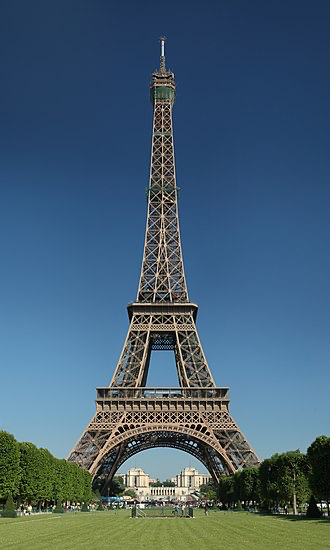


────────────────────────────────────────────────────────────────────────────────────────────────────
MODEL RESPONSES:
────────────────────────────────────────────────────────────────────────────────────────────────────



Model,Response,Length (chars),Time (s)
original,"The image shows the Eiffel Tower, a wrought-iron lattice tower, standing tall against a clear blue sky. The tower is the central focus of the image and appears to be a prominent landmark. Below the Eiffel Tower, a park is visible, featuring trees and green grass. In the distance, buildings and other structures can be seen, suggesting a city landscape. The overall impression is one of a picturesque view of the Eiffel Tower in a park setting, possibly in Paris.",464,5.020000
r1_alpha2_epochs1,"This is a high-resolution image of the Eiffel Tower in Paris, France. The tower is the central focus, a striking structure of iron latticework against a clear blue sky. The base of the tower is wide and somewhat sprawling, with a mix of green and brown vegetation. The upper part of the tower narrows significantly, culminating in a pointed top. The overall impression is one of verticality and intricate detail. The sky is bright blue with a few scattered, fluffy white clouds. The surrounding area shows a mix of green parks, lawns, and a few buildings with various architectural styles. The buildings are predominantly red brick with some brown accents and are relatively small compared to the Eiffel Tower. The colors are vibrant, with the greens of the park contrasting nicely with the blue of the sky and the brown of the buildings.",838,8.870000
r1_alpha4_epochs1,"The image shows the Eiffel Tower in Paris, France, with a clear, sunny sky and a slight blue tint. The tower is a prominent, intricate structure with detailed latticework and a distinct design. The surrounding area features a green lawn with a few scattered patches of grass. The buildings are a mix of architectural styles with a combination of low-rise and high-rise buildings. The overall impression is a tranquil and picturesque scene.",439,4.810000
r1_alpha4_epochs2,"The image shows the Eiffel Tower in Paris, France, under a clear blue sky. The tower's intricate lattice structure is prominently displayed, with alternating sections of dark and light indicating different levels. The base of the tower is surrounded by lush green lawns, suggesting a park-like setting. The foreground features scattered trees and bushes, adding a natural element to the urban landscape. In the distance, the iconic structures of Paris are visible, including the Louvre Museum and the Arc de Triomphe, offering a comprehensive view of the city's architecture. The overall atmosphere is one of serene beauty, showcasing the Eiffel Tower and its surrounding environment with remarkable clarity.",708,7.190000
r4_alpha4_epochs2,"This is a high-resolution image of the Eiffel Tower in Paris, France. The tower is the central focus, appearing as a prominent structure with intricate lattice designs on its various levels. The sky is a clear blue with a slight gradient from lighter at the top to slightly darker at the bottom. The ground is a grassy area with a mix of green and brown, suggesting a park or open space. In the distance, buildings with distinct architectural features are visible, indicating the presence of urban areas. The overall impression is one of a picturesque scene showcasing the Eiffel Tower against a backdrop of Parisian architecture and greenery.",643,6.600000
r16_alpha16_epochs2,"This is a detailed image of the Eiffel Tower in Paris, France. The tower is prominently featured with its iconic lattice structure and metallic color. The background shows a mix of urban and natural elements, with buildings, parks, and greenery visible. The overall atmosphere is one of elegance and sophistication, with the Eiffel Tower standing as a symbol of the city.",371,3.810000


In [46]:
show_image_question('General Image - Eiffel Tower')